# DelftaCalculator basics and $\Delta$-learning vs. direct learning 

In [1]:
import os
import glob
from openbabel.pybel import readfile, readstring
import numpy as np
from delfta.utils import TESTS_PATH, DATA_PATH

Next, we read a few example molecules from SDFs (structure data files) from the QMugs dataset. For more details on how to input your own molecules, see the documentation of the Pybel API [here](https://open-babel.readthedocs.io/en/latest/UseTheLibrary/Python_PybelAPI.html).

In [2]:
if not os.path.exists(os.path.join(TESTS_PATH)): 
    from delfta.download import TESTS_REMOTE, download
    import tarfile 
    
    download(TESTS_REMOTE, os.path.join(DATA_PATH, "test_data.tar.gz"))
    with tarfile.open(os.path.join(DATA_PATH, "test_data.tar.gz")) as handle:
        handle.extractall(DATA_PATH)

mol_files = glob.glob(os.path.join(TESTS_PATH, "mols_working", "CHEMBL*.sdf"))
mols = [next(readfile("sdf", mol_file)) for mol_file in mol_files]

We'll initialize a calculator by stating which tasks we want to perform. Options are `all` (the default), `E_form`, `E_homo`, `E_lumo`, `E_gap`, `dipole`, and `charges`. You can also choose between `delta=True` (run a GNF2-xTB calculation and predict a delta correction to obtain an approximation of the DFT-value ($\omega$B97X-D/def2-SVP)) or `delta=False` (predict the DFT-value directly from the molecular structure).

In [3]:
from delfta.calculator import DelftaCalculator

calc_delta = DelftaCalculator(tasks=["E_form", "E_homo", "E_lumo", "E_gap", "dipole", "charges"], delta=True) 
# We'll skip Wiberg bond orders in this tutorial as this requires some more verbose handling of atom/bond ids later on 
predictions_delta = calc_delta.predict(mols, batch_size=32) # lower the batch size if you run into memory issues
calc_direct = DelftaCalculator(tasks=["E_form", "E_homo", "E_lumo", "E_gap", "dipole", "charges"], delta=False) 
predictions_direct = calc_direct.predict(mols)

2021/12/08 06:17:05 PM | DelFTa | INFO: Now running xTB...
100%|██████████| 100/100 [00:28<00:00,  3.53it/s]
2021/12/08 06:17:33 PM | DelFTa | INFO: Now running network for model single_energy_delta...
100%|██████████| 100/100 [00:00<00:00, 131.78it/s]
2021/12/08 06:17:35 PM | DelFTa | INFO: Now running network for model multitask_delta...
100%|██████████| 100/100 [00:00<00:00, 157.75it/s]
2021/12/08 06:17:36 PM | DelFTa | INFO: Now running network for model charges_delta...
100%|██████████| 100/100 [00:00<00:00, 158.15it/s]
2021/12/08 06:17:37 PM | DelFTa | INFO: Now running network for model charges_direct...
100%|██████████| 100/100 [00:00<00:00, 160.94it/s]
2021/12/08 06:17:37 PM | DelFTa | INFO: Now running network for model single_energy_direct...
100%|██████████| 100/100 [00:00<00:00, 156.61it/s]
2021/12/08 06:17:38 PM | DelFTa | INFO: Now running network for model multitask_direct...
100%|██████████| 100/100 [00:00<00:00, 142.11it/s]


Let's put the output in a dataframe to get an overview: 

In [4]:
import pandas as pd

df = pd.DataFrame(predictions_delta)
df.insert(0, "structure", [os.path.basename(mol_file) for mol_file in mol_files])
df.rename(columns={"E_form": "E_form [Ha]", "E_homo": "E_homo [Ha]", "E_lumo": "E_lumo [Ha]", "E_gap": "E_gap [Ha]", "dipole": "dipole [D]", "charges": "charges [e]"})

,structure,E_form [Ha],E_homo [Ha],E_lumo [Ha],E_gap [Ha],dipole [D],charges [e]
0,CHEMBL225201_conf_02.sdf,-8.813721,-0.274999,0.005881,0.280759,7.328785,"[-0.030875619599075324, 0.005195767134704592, ..."
1,CHEMBL3917059_conf_01.sdf,-10.935448,-0.273494,0.009785,0.283435,10.684330,"[0.054004443623275764, -0.1176872677693367, -0..."
2,CHEMBL498248_conf_02.sdf,-7.160987,-0.310790,-0.055976,0.254909,2.619457,"[0.16150189902526857, -0.4162774630255127, 0.1..."
3,CHEMBL2178189_conf_01.sdf,-10.881596,-0.279899,0.031184,0.311134,8.439722,"[0.13710493664514542, -0.3518399607843399, 0.2..."
4,CHEMBL1702692_conf_00.sdf,-7.063443,-0.278748,-0.029215,0.249319,6.440857,"[0.13054176561258315, -0.33679879455505374, 0...."
...,...,...,...,...,...,...,...
95,CHEMBL549536_conf_00.sdf,-6.982763,-0.284059,-0.000596,0.283686,7.779823,"[0.0775152101145935, -0.0325183975387001, -0.1..."
96,CHEMBL3911894_conf_02.sdf,-8.601434,-0.297836,0.008123,0.305994,1.267288,"[-0.13680183943115232, 0.20445370790084838, -0..."
97,CHEMBL3310704_conf_00.sdf,-9.649964,-0.272366,0.040883,0.313243,4.099394,"[0.14251945604553223, -0.3266561704756737, 0.2..."
98,CHEMBL1731586_conf_00.sdf,-9.637108,-0.251576,0.027726,0.279228,2.892029,"[0.09452940721343994, -0.38360732514808654, 0...."


Get the DFT-calculated values from the QMugs SDFs and prepare everything for plotting:

In [5]:
predictions_delta["charges"] = np.concatenate(predictions_delta["charges"])
predictions_direct["charges"] = np.concatenate(predictions_direct["charges"])
dft_keys = ["DFT:FORMATION_ENERGY", "DFT:HOMO_ENERGY", "DFT:LUMO_ENERGY", "DFT:HOMO_LUMO_GAP", "DFT:DIPOLE", "DFT:MULLIKEN_CHARGES"]
dft_values = {}
for dft_key in dft_keys:
    if dft_key == "DFT:DIPOLE": 
        dft_values[dft_key] =  [float(mol.data[dft_key].split("|")[-1]) for mol in mols]
    elif dft_key == "DFT:MULLIKEN_CHARGES": 
        dft_values[dft_key] = [float(elem) for mol in mols for elem in mol.data[dft_key].split("|")]
    else:
        dft_values[dft_key] = [float(mol.data[dft_key]) for mol in mols]



2021/12/08 06:17:39 PM | matplotlib.font_manager | INFO: Generating new fontManager, this may take some time...


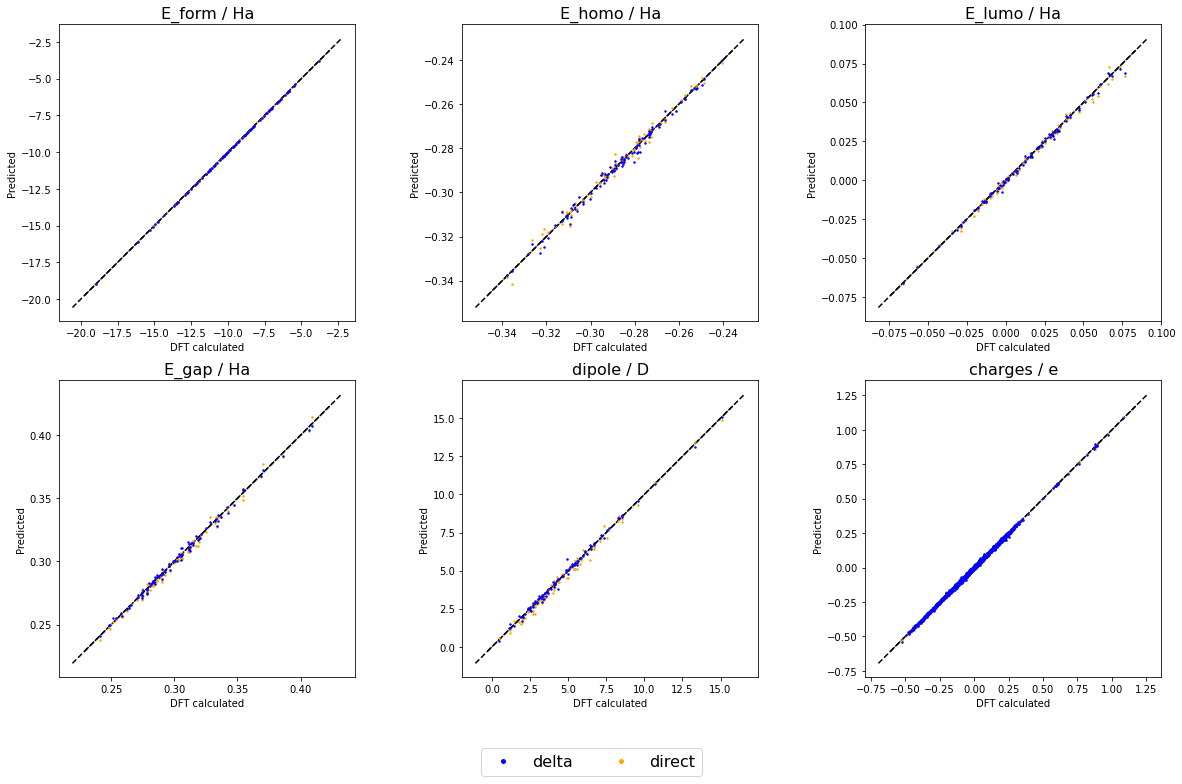

In [6]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

def make_plot(ax, dft_vals, pred_vals, color): 
    ax.scatter(dft_vals, pred_vals, color=color, s=2)
    ax.set_xlabel("DFT calculated")
    ax.set_ylabel("Predicted")
    min_val = [min(ax.get_ylim()[0], ax.get_xlim()[0])]
    max_val = [max(ax.get_ylim()[1], ax.get_xlim()[1])]
    ax.plot([min_val, max_val], [min_val, max_val], '--', color="black", zorder=-1)
    ax.set_aspect("equal", "box")

fig = plt.figure(figsize=(20, 12))
gs = GridSpec(nrows=2, ncols=3)
gs.update(wspace=0.3, hspace=0.2)
pred_keys = ["E_form", "E_homo", "E_lumo", "E_gap", "dipole", "charges"]
all_dft_vals = [dft_values[dft_key] for dft_key in dft_keys]
all_pred_vals_delta = [predictions_delta[pred_key] for pred_key in pred_keys]
all_pred_vals_direct = [predictions_direct[pred_key] for pred_key in pred_keys]
units = ["Ha", "Ha", "Ha", "Ha", "D", "e"]
axes = [fig.add_subplot(gs[i,j]) for i in range(2) for j in range(3)]
for ax, pred_key, dft_key, unit in zip(axes, pred_keys, dft_keys, units): 
    make_plot(ax, dft_values[dft_key], predictions_direct[pred_key], "orange")
    make_plot(ax, dft_values[dft_key], predictions_delta[pred_key], "blue")
    ax.title.set_text(f"{pred_key} / {unit}")
    ax.title.set_fontsize(16)

handles = [Line2D([0], [0], marker='o', color="white", markerfacecolor="blue"), Line2D([0], [0], marker='o', color="white", markerfacecolor="orange")]
fig.legend(handles, ["delta", "direct"], fontsize=16, loc="lower center", ncol=2)

As you can see, both $\Delta$- and direct-learning approximate the $\omega$B97X-D/def2-SVP ground truth well. Check our paper for a more detailed discussion.

You can also create molecules directly from SMILES. In that case, you need to keep `force3D=True` (the default), so that the Pybel generates a three-dimensional structure for the molecule using the MMFF94 force field. Alternatively, you can create three-dimensional coordinates in some other way and feed the molecule to the calculator afterwards.

In [7]:
mols = [readstring("smi", "O=C(C)Oc1ccccc1C(=O)O")] # aspirin
calc = DelftaCalculator(delta=True, force3d=True)
preds_delta = calc.predict(mols)
print(preds_delta)

2021/12/08 06:17:41 PM | DelFTa | INFO: Assigned MMFF94 coordinates and added hydrogens to molecules at position(s) [0]
2021/12/08 06:17:41 PM | DelFTa | INFO: Now running xTB...
100%|██████████| 1/1 [00:00<00:00, 11.33it/s]
2021/12/08 06:17:41 PM | DelFTa | INFO: Now running network for model single_energy_delta...
100%|██████████| 1/1 [00:00<00:00, 122.50it/s]
2021/12/08 06:17:41 PM | DelFTa | INFO: Now running network for model multitask_delta...
100%|██████████| 1/1 [00:00<00:00, 128.79it/s]
2021/12/08 06:17:41 PM | DelFTa | INFO: Now running network for model charges_delta...
100%|██████████| 1/1 [00:00<00:00, 65.51it/s]
2021/12/08 06:17:41 PM | DelFTa | INFO: Now running network for model wbo_delta...
100%|██████████| 1/1 [00:00<00:00, 60.47it/s]

{'E_form': array([-3.8762815], dtype=float32), 'E_homo': array([-0.34509787], dtype=float32), 'E_lumo': array([-0.01114559], dtype=float32), 'E_gap': array([0.33391201], dtype=float32), 'dipole': array([3.698949], dtype=float32), 'charges': [array([-0.19695041,  0.18014771, -0.09179275, -0.2915747 ,  0.20729421,
       -0.04023171,  0.01246643, -0.00152081, -0.01100436, -0.10213734,
        0.19624388, -0.2294366 , -0.19212152,  0.06875062,  0.0843718 ,
        0.07212227,  0.03232232,  0.03542026,  0.02956192,  0.0426783 ,
        0.21608485])], 'wbo': [{'0-1': 2.2922393119399898, '0-3': 0.15052526246164533, '1-2': 1.0618275224391063, '1-3': 1.2581694726330652, '2-13': 0.9273212582222881, '2-14': 0.9442758618455975, '2-15': 0.9486681854011312, '3-4': 1.17273141301408, '4-5': 1.41910056634316, '4-9': 1.365871508336803, '5-6': 1.470211942518288, '5-8': 0.11313759159555414, '5-16': 0.926460847769334, '6-7': 1.4510870471804158, '6-17': 0.9309598911554917, '7-8': 1.4754809913379463, '7-18'